<a href="https://colab.research.google.com/github/eutiagovski/amex-default-predicition/blob/main/model-selection/Amex_Default_Model_Selection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
!pip install mljar-supervised

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 113 kB 4.2 MB/s 
     |████████████████████████████████| 38.1 MB 1.2 MB/s 
     |████████████████████████████████| 192.9 MB 74 kB/s 
     |████████████████████████████████| 2.0 MB 39.2 MB/s 
     |████████████████████████████████| 76.6 MB 1.2 MB/s 
     |████████████████████████████████| 61 kB 271 kB/s 
     |████████████████████████████████| 319 kB 67.0 MB/s 
     |████████████████████████████████| 366 kB 65.9 MB/s 
     |████████████████████████████████| 69 kB 7.5 MB/s 
     |████████████████████████████████| 308 kB 76.0 MB/s 
     |████████████████████████████████| 81 kB 11.0 MB/s 
     |████████████████████████████████| 209 kB 76.6 MB/s 
     |████████████████████████████████| 78 kB 8.0 MB/s 
     |████████████████████████████████| 146 kB 75.4 MB/s 
     |████████████████████████████████| 49 kB 6.8 MB/s 
     |████████████████████████████████| 1

In [2]:
# imports

import os
import gc
import glob
import tqdm
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.metrics import mean_squared_error
# from supervised.automl import AutoML # mljar-supervised

from sklearn.model_selection import train_test_split

In [3]:
# load data

SEED = 42
os.environ['PYTHONHASHSEED'] = str(SEED)

train_labels = pd.read_csv('/content/drive/MyDrive/kaggle/amex-default-predict/train_labels.csv')
train_labels['customer_ID'] = train_labels['customer_ID'].apply(lambda x: int(x[-16:], 16)).astype(np.int64)
train_labels = train_labels.set_axis(train_labels['customer_ID'])
train_labels = train_labels.drop(['customer_ID'], axis=1)

train_pkls = sorted(glob.glob('/content/drive/MyDrive/kaggle/amex-default-predict/train_data_*'))
train_y = sorted(glob.glob('/content/drive/MyDrive/kaggle/amex-default-predict/train_y_*.npy'))

train_df = pd.read_pickle(train_pkls[0])
df_features = pd.read_pickle('/content/drive/MyDrive/kaggle/amex-default-predict/XGB_model_0.7790193265518999_feature_importance.pkl')



In [4]:
# amex meric

def amex_metric(y_true, y_pred):
    labels     = np.transpose(np.array([y_true, y_pred]))
    labels     = labels[labels[:, 1].argsort()[::-1]]
    weights    = np.where(labels[:,0]==0, 20, 1)
    cut_vals   = labels[np.cumsum(weights) <= int(0.04 * np.sum(weights))]
    top_four   = np.sum(cut_vals[:,0]) / np.sum(labels[:,0])

    gini = [0,0]
    for i in [1,0]:
        labels         = np.transpose(np.array([y_true, y_pred]))
        labels         = labels[labels[:, i].argsort()[::-1]]
        weight         = np.where(labels[:,0]==0, 20, 1)
        weight_random  = np.cumsum(weight / np.sum(weight))
        total_pos      = np.sum(labels[:, 0] *  weight)
        cum_pos_found  = np.cumsum(labels[:, 0] * weight)
        lorentz        = cum_pos_found / total_pos
        gini[i]        = np.sum((lorentz - weight_random) * weight)

    return 0.5 * (gini[1]/gini[0] + top_four)

In [ ]:
# since the data was splitted, i'll be training each part with a diferent model


(76486, 1331) (61188, 1331) (15298, 1331) (61188,) (15298,)


In [ ]:
# model 0: AutoML

index = 0

train_df = pd.read_pickle(train_pkls[index])


y = np.load(train_y[index])
X_train, X_val, y_train, y_val = train_test_split(train_df, y, stratify=y, test_size=0.20, random_state=SEED)

print(train_df.shape, X_train.shape, X_val.shape, y_train.shape, y_val.shape)

In [ ]:
# searching the best model with AutoML

automl = AutoML() 
automl.fit(X_train, pd.DataFrame(y_train))

prediction = automl.predict_proba(X_val)

automl_val_score = amex_metric(y_true=y_val.reshape(-1, ), y_pred=prediction[:, 1].reshape(-1, ).astype(np.float32))
automl_val_score

Linear algorithm was disabled.
AutoML directory: AutoML_1
The task is binary_classification with evaluation metric logloss
AutoML will use algorithms: ['Baseline', 'Decision Tree', 'Random Forest', 'Xgboost', 'Neural Network']
AutoML will ensemble available models
AutoML steps: ['simple_algorithms', 'default_algorithms', 'ensemble']
* Step simple_algorithms will try to check up to 2 models
1_Baseline logloss 0.571945 trained in 20.21 seconds


Disable SHAP explanations because of number of columns > 500.


2_DecisionTree logloss 0.304945 trained in 130.63 seconds
* Step default_algorithms will try to check up to 3 models


Disable SHAP explanations because of number of columns > 500.


3_Default_Xgboost logloss 0.230052 trained in 463.26 seconds
4_Default_NeuralNetwork logloss 0.253008 trained in 190.93 seconds


Disable SHAP explanations because of number of columns > 500.


5_Default_RandomForest logloss 0.276534 trained in 1516.2 seconds
* Step ensemble will try to check up to 1 model
Ensemble logloss 0.227585 trained in 2.79 seconds
AutoML fit time: 2345.23 seconds
AutoML best model: Ensemble


AutoML()

In [ ]:
automl = AutoML('/content/drive/MyDrive/kaggle/amex-default-predict/AutoML_1') 
automl.fit(X_train, pd.DataFrame(y_train))

prediction = automl.predict_proba(X_val)

automl_val_score = amex_metric(y_true=y_val.reshape(-1, ), y_pred=prediction[:, 1].reshape(-1, ).astype(np.float32))
automl_val_score

Linear algorithm was disabled.
This model has already been fitted. You can use predict methods or select a new 'results_path' for a new 'fit()'.


0.8367837635688992

In [ ]:
# model 2: Voting Classifier
# https://github.com/eutiagovski/projetos-cursos/blob/main/datascience-mentorama/14_Deteccao_Anomalias_exercicio_.ipynb

index = 1

train_df = pd.read_pickle(train_pkls[index])


y = np.load(train_y[index])
X_train, X_val, y_train, y_val = train_test_split(train_df, y, stratify=y, test_size=0.20, random_state=SEED)

print(train_df.shape, X_train.shape, X_val.shape, y_train.shape, y_val.shape)

(76486, 1331) (61188, 1331) (15298, 1331) (61188,) (15298,)


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import VotingClassifier

logreg = LogisticRegression()
knn = KNeighborsClassifier()
dt = DecisionTreeClassifier()

estimators = [('lr', logreg), ('knn', knn), ('dt', dt)]

voting = VotingClassifier(estimators = estimators, voting='soft')

X_train.replace([np.NaN, np.inf, -np.inf], 0, inplace=True)
X_val.replace([np.NaN, np.inf, -np.inf], 0, inplace=True)

voting.fit(X_train, y_train)

prediction = voting.predict_proba(X_val)

votting_val_score = amex_metric(y_true=y_val.reshape(-1, ), y_pred=prediction[:, 1].reshape(-1, ).astype(np.float32))
votting_val_score

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


ValueError: ignored

In [ ]:
X_val.replace([np.NaN, np.inf, -np.inf], 0, inplace=True)

prediction = voting.predict_proba(X_val)

votting_val_score = amex_metric(y_true=y_val.reshape(-1, ), y_pred=prediction[:, 1].reshape(-1, ).astype(np.float32))
votting_val_score

0.6536787199605953

In [ ]:
# model 3: Detector de Anomalias
# https://github.com/eutiagovski/projetos-cursos/blob/main/datascience-mentorama/14_Deteccao_Anomalias_exercicio_.ipynb

index = 2

train_df = pd.read_pickle(train_pkls[index])


y = np.load(train_y[index])
X_train, X_val, y_train, y_val = train_test_split(train_df, y, stratify=y, test_size=0.20, random_state=SEED)

print(train_df.shape, X_train.shape, X_val.shape, y_train.shape, y_val.shape)

(76486, 1331) (61188, 1331) (15298, 1331) (61188,) (15298,)


In [ ]:
import pandas as pd 
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt
from sklearn.base import BaseEstimator

class DetectorAnomalias(BaseEstimator):
    
    def __init__(self, epsilon):
        self.epsilon = epsilon
        
    def fit(self, X, y=None):
        medias = X.mean(axis = 0)
        desvios = X.std(axis = 0)
        gaussianas = [st.norm(loc = m, scale = d) for m, d in zip(medias, desvios)]  
        self.gaussianas = gaussianas
        self.X = X
        
    def prob(self, x):
        p = 1
        for i in range(self.X.shape[1]):
            gaussiana_i = self.gaussianas[i]
            x_i = x[i]
            p *= gaussiana_i.pdf(x_i)
        return p
    
    def isAnomaly(self, x):
        return int(np.where(self.prob(x) < self.epsilon, 1, 0))

detector = DetectorAnomalias(epsilon=1e-7)

In [ ]:
detector.fit(X_train)

anomaly_test = []

for i in range(X_val.shape[0]):
  anomaly_test.append(detector.isAnomaly(X_val.loc[X_val.index[i]]))

detector_val_score = amex_metric(y_true=y_val.reshape(-1, ), y_pred=anomaly_test[:, 1].reshape(-1, ).astype(np.float32))
detector_val_score

overflow encountered in reduce
invalid value encountered in double_scalars
divide by zero encountered in double_scalars


KeyboardInterrupt: ignored

In [ ]:
# Comparing the best model 

In [ ]:
import matplotlib.pyplot as plt 


plt.barh([automl_val_score, automl_xgboost])
plt.plot()

AutoML directory: AutoML_3
The task is binary_classification with evaluation metric logloss
AutoML will use algorithms: ['Xgboost']
AutoML will ensemble available models
AutoML steps: ['simple_algorithms', 'default_algorithms', 'ensemble']
Skip simple_algorithms because no parameters were generated.
* Step default_algorithms will try to check up to 1 model


Disable SHAP explanations because of number of columns > 500.


1_Default_Xgboost logloss 0.230052 trained in 435.12 seconds
* Step ensemble will try to check up to 1 model
AutoML fit time: 448.91 seconds
AutoML best model: 1_Default_Xgboost


AutoML(algorithms=['Xgboost'])

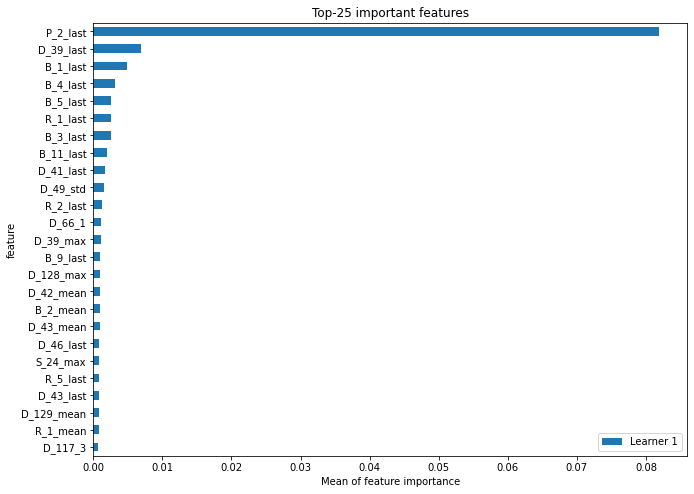

In [ ]:
# using xgboost model for this task

automl_xgboost = AutoML(algorithms=['Xgboost'])
automl.automl_xgboost(X_train, pd.DataFrame(y_train))

prediction = automl_xgboost.predict_proba(X_val)

automl_xgboost_val_score = amex_metric(y_true=y_val.reshape(-1, ), y_pred=prediction[:, 1].reshape(-1, ).astype(np.float32))
automl_xgboost_val_score

In [ ]:
#  tunning the best model to get the best score

In [5]:
!pip install ConfigSpace

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.7 MB 4.3 MB/s 


In [6]:
# class optimezer for tunning xgboost with xgboost https://towardsdatascience.com/tuning-xgboost-with-xgboost-writing-your-own-hyper-parameters-optimization-engine-a593498b5fba

import pandas as pd
import numpy as np

class Optimizer:
    """
    This class optimise an algorithm/model configuration with respect to a given score.
    """
    def __init__(self,
                 algo_score,
                 max_iter,
                 max_intensification,
                 model,
                 cs):
        """
        :param algo_score: is the function called to evaluate algorithm / model score
        :param max_iter: the maximal number of training to perform
        :param max_intensification: the maximal number of candidates configuration to sample randomly
        :param model: the class of the internal model used as score estimator.
        :param cs: the configuration space to explore
        """
        self.traj = []
        self.algo_score = algo_score
        self.max_iter = max_iter
        self.max_intensification = max_intensification
        self.internal_model = model()
        self.trajectory = []
        self.cfgs = []
        self.scores = {}
        self.best_cfg = None
        self.best_score = None
        self.cs = cs

    def cfg_to_dtf(self, cfgs):
        """
        Convert configs list into pandas DataFrame to ease learning
        """
        cfgs = [dict(cfg) for cfg in cfgs]
        dtf = pd.DataFrame(cfgs)
        return dtf


    def optimize(self):
        """
        Optimize algo/model using internal score estimator
        """
        cfg = self.cs.sample_configuration()
        self.cfgs.append(cfg)
        self.trajectory.append(cfg)
        # initial run
        score = self.algo_score(cfg)
        self.scores[cfg] = score
        self.best_cfg = cfg
        self.best_score = score

        dtf = self.cfg_to_dtf(self.cfgs)


        for i in range(0, self.max_iter):
            # We need at least two datapoints for training
            if dtf.shape[0] > 1:
                scores = np.array([ val for key, val in self.scores.items()])
                self.internal_model.fit(dtf, scores)
                # intensification
                candidates = [self.cs.sample_configuration() for i in range(0, self.max_intensification)]
                candidate_scores = [self.internal_model.predict(self.cfg_to_dtf([cfg])) for cfg in candidates]
                best_candidates = np.argmax(candidate_scores)

                cfg = candidates[best_candidates]
                self.cfgs.append(cfg)
                score = self.algo_score(cfg)
                self.scores[cfg] = score

                if score > self.best_score:
                    self.best_cfg = cfg
                    self.best_score = score
                    self.trajectory.append(cfg)

                dtf = self.cfg_to_dtf(self.cfgs)
                self.internal_model.fit(dtf,
                                        np.array([val for kay, val in self.scores.items()]))
            else:
                cfg = self.cs.sample_configuration()
                self.cfgs.append(cfg)
                score = self.algo_score(cfg)
                self.scores[cfg] = score

                if score > self.best_score:
                    self.best_cfg = cfg
                    self.best_score = score
                    self.trajectory.append(cfg)
                dtf = self.cfg_to_dtf(self.cfgs)

In [10]:
import numpy as np
import pandas as pd
from ConfigSpace import ConfigurationSpace
from ConfigSpace.hyperparameters import CategoricalHyperparameter, \
    UniformFloatHyperparameter, UniformIntegerHyperparameter
from sklearn.datasets import load_boston
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostClassifier
from xgboost.sklearn import XGBClassifier
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_val_score

import matplotlib.pyplot as plt

def run(data, target, cfg):
    cfg_dict = {key: cfg[key] for key in cfg}
    rfr = XGBClassifier(**cfg_dict)

    def rmse(y, y_pred):
        return np.sqrt(np.mean((y_pred - y) ** 2))

    # Creating root mean square error for sklearns crossvalidation
    rmse_scorer = make_scorer(rmse, greater_is_better=False)
    score = cross_val_score(rfr, data, target, cv=11, scoring=rmse_scorer, verbose=0)
    score = np.mean(score)

    return score  # Because cross_validation sign-flips the score


num_trees = UniformIntegerHyperparameter("n_estimators", 10, 150, default_value=10)
max_depth = UniformIntegerHyperparameter("max_depth", 1, 10, default_value=5)
learning_rate = UniformFloatHyperparameter("learning_rate", 0.0, 1.0, default_value=0.7)
gamma = UniformFloatHyperparameter("gamma", 0.1, 10, default_value=1)
subsample = UniformFloatHyperparameter("subsample", 0.1, 1.0, default_value=0.7)
colsample_bytree = UniformFloatHyperparameter("colsample_bytree", 0.1, 1, default_value=0.7)

cs = ConfigurationSpace()
cs.add_hyperparameters([num_trees, learning_rate,
                        max_depth, gamma,
                        subsample, colsample_bytree])



[n_estimators, Type: UniformInteger, Range: [10, 150], Default: 10,
 learning_rate, Type: UniformFloat, Range: [0.0, 1.0], Default: 0.7,
 max_depth, Type: UniformInteger, Range: [1, 10], Default: 5,
 gamma, Type: UniformFloat, Range: [0.1, 10.0], Default: 1.0,
 subsample, Type: UniformFloat, Range: [0.1, 1.0], Default: 0.7,
 colsample_bytree, Type: UniformFloat, Range: [0.1, 1.0], Default: 0.7]

In [ ]:
# model 3: Detector de Anomalias
# https://github.com/eutiagovski/projetos-cursos/blob/main/datascience-mentorama/14_Deteccao_Anomalias_exercicio_.ipynb

index = 3

train_df = pd.read_pickle(train_pkls[index])


y = np.load(train_y[index])
X_train, X_val, y_train, y_val = train_test_split(train_df, y, stratify=y, test_size=0.20, random_state=SEED)

print(train_df.shape, X_train.shape, X_val.shape, y_train.shape, y_val.shape)

data = X_train
target = y_train

max_intensification = 25

optimizer_xgb = Optimizer(lambda cfg: run(data, target, cfg),
                          50, 250,
                          XGBClassifier,
                          cs)
optimizer_xgb.optimize()

optimizer_cat = Optimizer(lambda cfg: run(data, target, cfg),
                          50, 250,
                          CatBoostClassifier,
                          cs)
optimizer_cat.optimize()


cfg_traj = [cfg for cfg in optimizer_xgb.trajectory]
plt.plot([-optimizer_xgb.scores[cfg] if cfg in cfg_traj else None for cfg in optimizer_xgb.cfgs], 'go')
plt.plot([-optimizer_xgb.scores[cfg] for cfg in optimizer_xgb.cfgs], 'g')

cfg_traj = [cfg for cfg in optimizer_cat.trajectory]
plt.plot([-optimizer_cat.scores[cfg] if cfg in cfg_traj else None for cfg in optimizer_cat.cfgs], 'ro')
plt.plot([-optimizer_cat.scores[cfg] for cfg in optimizer_cat.cfgs], 'r')


plt.title('SMAC scores')
plt.legend(['Tested configuration (XGBost)', 'Selected incumbent (XGBoost)',
            'Tested configuration (CatBoost)', 'Selected incumbent (CatBoost)'])
plt.xlabel('Number of iterations')
plt.ylabel('Score')
plt.show()

(76485, 1331) (61188, 1331) (15297, 1331) (61188,) (15297,)


In [ ]:
xgboost_features = pd.read_pickle('/content/drive/MyDrive/kaggle/amex-default-predict/XGB_model_0.7790193265518999_feature_importance.pkl')
best_features = xgboost_features.loc[xgboost_features.score >= 10]

best_features

,score
P_2_last,56
D_39_last,42
B_1_last,15
D_42_max,14
B_5_last,14
R_1_last,14
B_3_std,13
B_11_last,13
B_4_last,12
B_2_last,12
